In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import os
import matplotlib.pyplot as plt

In [7]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [ ]:
# Az a dataset ami egyszerre az össszes adatot betölti ha esetleg később kellene
import pickle

class BiosensorDatasetAll(Dataset):
    def __init__(self, data_path, transform=None):
        self.transform = transform
        with open(data_path + '/alldata.pkl', 'rb') as in_file:
            data = pickle.load(in_file)
            self.filename = data['old_filename']
            self.biosensor = data['biosensor']
            self.masks = data['masks']
        
    def __getitem__(self, index): 
        if self.transform:
            return self.transform(self.biosensor[index]), self.transform(self.masks[index])
        
    def __len__(self):
        return len(self.data)

In [62]:
class BiosensorDatasetIntMask(Dataset):
    def __init__(self, path, transform=None, biosensor_length=128, mask_size=80):
        self.transform = transform
        self.path = path
        self.length = biosensor_length
        self.mask_size = mask_size
        
        
    def __getitem__(self, index):
        # If the index is a list of indices
        if isinstance(index, slice):
            start, stop, step = index.indices(len(self))
            indices = range(start, stop, step)
            biosensor = []
            masks = []
            for i in indices:
                data = np.load(self.path + str(i) + '.npz')
                
                bio = self.uniform_time_dim(torch.from_numpy(data['biosensor']))
                mask = self.uniform_mask(torch.from_numpy(data['mask'].astype(np.int32)))
                if self.transform:
                    data = self.transform(bio, mask)
                
                biosensor.append(bio)
                masks.append(mask)
            biosensor = torch.stack(biosensor)
            masks = torch.stack(masks)
            return biosensor, masks
        
        # Only one index
        data = np.load(self.path + str(index) + '.npz')
        bio = self.uniform_time_dim(torch.from_numpy(data['biosensor']))
        mask = self.uniform_mask(torch.from_numpy(data['mask'].astype(np.int32))) #bool vagy np.int32???
        if self.transform:
            data = self.transform(bio, mask)
        return bio, mask
        
    def __len__(self):
        # Ezt lehetne jobban de egyelőre csak az npz fájlok vannak a mappában
        return len(os.listdir(self.path))
    
    def uniform_time_dim(self, biosensor):
        indices = np.linspace(0, biosensor.shape[0] - 1, self.length, dtype=int)
        return biosensor[indices]
    
    def uniform_mask(self, mask):
        return torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=(self.mask_size, self.mask_size), mode='nearest').squeeze(0).squeeze(0).byte()


In [63]:
class BiosensorDatasetBoolMask(Dataset):
    def __init__(self, path, transform=None, biosensor_length=128, mask_size=80):
        self.transform = transform
        self.path = path
        self.length = biosensor_length
        self.mask_size = mask_size
        
        
    def __getitem__(self, index):
        # If the index is a list of indices
        if isinstance(index, slice):
            start, stop, step = index.indices(len(self))
            indices = range(start, stop, step)
            biosensor = []
            masks = []
            for i in indices:
                data = np.load(self.path + str(i) + '.npz')
                
                bio = self.uniform_time_dim(torch.from_numpy(data['biosensor']))
                mask = self.uniform_mask(torch.from_numpy(data['mask'].astype(bool)))
                if self.transform:
                    data = self.transform(bio, mask)
                
                biosensor.append(bio)
                masks.append(mask)
            biosensor = torch.stack(biosensor)
            masks = torch.stack(masks)
            return biosensor, masks
        
        # Only one index
        data = np.load(self.path + str(index) + '.npz')
        bio = self.uniform_time_dim(torch.from_numpy(data['biosensor']))
        mask = self.uniform_mask(torch.from_numpy(data['mask'].astype(bool))) #bool vagy np.int32???
        if self.transform:
            data = self.transform(bio, mask)
        return bio, mask
        
    def __len__(self):
        # Ezt lehetne jobban de egyelőre csak az npz fájlok vannak a mappában
        return len(os.listdir(self.path))
    
    def uniform_time_dim(self, biosensor):
        indices = np.linspace(0, biosensor.shape[0] - 1, self.length, dtype=int)
        return biosensor[indices]
    
    def uniform_mask(self, mask):
        return torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=(self.mask_size, self.mask_size), mode='nearest').squeeze(0).squeeze(0).byte()


In [ ]:
# Transform ami downsample-eli a biosenzor időtartamát
class DownsampleBiosensorLength:
    def __init__(self, length):
        self.length = length

    def __call__(self, data):
        indices = np.linspace(0, data['biosensor'].shape[0] - 1, self.length, dtype=int)
        data['biosensor'] = data['biosensor'][indices]
        return data

# Mask interpoláció 80x80-ra
class Interpolate:
    def __init__(self, size):
        self.size = size

    def __call__(self, data):
        data['mask'] = torch.nn.functional.interpolate(data['mask'].unsqueeze(0).unsqueeze(0).float(), size=(self.size, self.size), mode='nearest').squeeze(0).byte()
        return data
    
# Milyen egyép transzformációkra lehet szükség?
class Normalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, bio, mask):
        
        return bio, mask
    


In [10]:
# Bioszenzor idősor downsample-elése interpolációval
def downsample_first_dim(tensor, size):
    # The tensor dimensions need to be (batch_size, channels, depth, height, width) for 3D input
    # So we reshape our tensor to (1, 1, 700, 80, 80)
    tensor = tensor.reshape(1, 1, *tensor.shape)
    # Downsample the first dimension
    downsampled_tensor = torch.nn.functional.interpolate(tensor, size=(size, tensor.shape[3], tensor.shape[4]), mode='trilinear', align_corners=False)
    # Remove the added dimensions
    downsampled_tensor = downsampled_tensor.squeeze(0).squeeze(0)
    return downsampled_tensor

# Bioszenzor idősor downsample-elése az első dimenzió mentén egyenletesen
def downsample_first_dim(tensor, size):
    # Generate evenly spaced indices
    indices = np.linspace(0, tensor.shape[0] - 1, size, dtype=int)
    print(indices)
    # Select the frames from the tensor
    downsampled_tensor = tensor[indices]
    return downsampled_tensor

In [64]:
data80 = BiosensorDatasetIntMask(path = 'data/', biosensor_length=128, mask_size=80)
data_loader80 = DataLoader(data80, batch_size=1, shuffle=False)

data4000 = BiosensorDatasetIntMask(path = 'data/', biosensor_length=128, mask_size=4000)
data_loader4000 = DataLoader(data4000, batch_size=1, shuffle=False)

torch.Size([4, 128, 80, 80])
torch.Size([4, 4000, 4000])
tensor([  0,   4,   7,   8,  11,  13,  14,  15,  16,  17,  19,  21,  22,  23,
         26,  27,  28,  29,  30,  31,  32,  38,  39,  40,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  51,  52,  53,  54,  55,  56,  57,  58,  59,
         60,  62,  63,  65,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  80,  81,  82,  83,  84,  85,  89,  90,  91,  94,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 114, 117, 118,
        119, 120], dtype=torch.uint8)
86


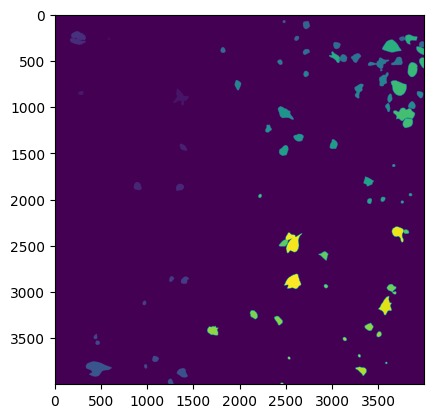

In [59]:
for bio, mask in data_loader4000:
    print(bio.shape)
    print(mask.shape)
    plt.imshow(mask[0])
    print(mask[0].unique())
    print(len(mask[0].unique()))
    break

torch.Size([4, 128, 80, 80])
torch.Size([4, 80, 80])
tensor([  0,   7,   8,  11,  13,  14,  15,  16,  17,  19,  21,  22,  26,  27,
         28,  30,  31,  32,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  52,  53,  54,  55,  56,  57,  58,  59,  60,  62,  63,  65,  67,
         68,  70,  71,  72,  73,  75,  76,  77,  78,  80,  81,  82,  83,  84,
         89,  90,  91,  94,  97,  98,  99, 100, 101, 103, 106, 114, 117, 118,
        119, 120], dtype=torch.uint8)
72


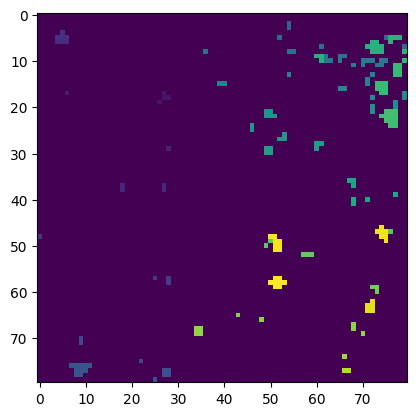

In [60]:
for bio, mask in data_loader80:
    print(bio.shape)
    print(mask.shape)
    plt.imshow(mask[0])
    print(mask[0].unique())
    print(len(mask[0].unique()))
    break

In [88]:
# Érdekes lehet megnézni hogy a leinterpolált maszkokon hány sejt van
# Ha intként marad akkor a különböző számokat megnézni az eredeti és a leinterpolált maszkokon (unique)
# Lehet hogy a leinterpolált maszkokon sokkal kevesebb sejt lesz mert összeolvadnak
unique4000 = []
max4000 = []
unique80 = []
for bio, mask in data_loader4000:
    unique4000.append(len(mask[0].unique()))
    max4000.append(mask[0].max().item())
for bio, mask in data_loader80:
    unique80.append(len(mask[0].unique()))

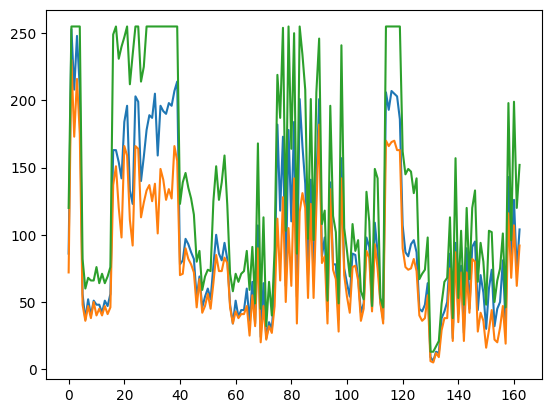

In [89]:
plt.plot(unique4000, label='4000')
plt.plot(unique80, label='80')
plt.plot(max4000, label='max')

In [90]:
avg80 = sum(unique80) / len(unique80)
avg4000 = sum(unique4000) / len(unique4000)
max4000 = sum(max4000) / len(max4000)
print(avg80, avg4000, max4000)

78.53374233128834 96.99386503067484 135.11656441717793


In [26]:
bio, mask = data[0:10]
print(bio.shape)

torch.Size([10, 128, 80, 80])
